# Dosed Training and Evaluation

Requirements:

1. You need the data for training as h5 files, to get them you either:
  - Go through `download_and_data_format_explanation.ipynb`

    or 

  - Run `make download_example`  you can use optionnal DOWNLOAD_PATH env variable to specify an alternative directory
  
2. Have dosed installed:
    
  - Run `pip install -e .` from dosed root directory
  or 
  - Run `python setup.py develop` from dosed root directory
  


In [1]:
%matplotlib inline

In [2]:
import os
import json

h5_directory = '/gpfs/users/idrissib/datasets/sleepapnea/records/train'  # adapt if you used a different DOWNLOAD_PATH when running `make download_example`

# 1. Train, validation and test dataset creation

## First we select which records we want to train, validate and test on

In [3]:
import torch
import tempfile
import json
import random


from dosed.utils import Compose
from dosed.datasets import BalancedEventDataset as dataset
from dosed.models import DOSED3 as model
from dosed.datasets import get_train_validation_test
from dosed.trainers import trainers
from dosed.preprocessing import GaussianNoise, RescaleNormal, Invert

seed = 2019

In [4]:
train, validation, test = get_train_validation_test(h5_directory,
                                                    percent_test=0,
                                                    percent_validation=33,
                                                    seed=seed)

print("Number of records train:", len(train))
print("Number of records validation:", len(validation))
print("Number of records test:", len(test))

Number of records train: 15
Number of records validation: 7
Number of records test: 0


## Then we use the dataset class that will be use to generate sample for training and evaluation

- h5_directory: Location of the generic h5 files.
- signals: the signals from the h5 we want to include together with their normalization
- events: the evvents from the h5 we want to train on
- window: Spindles have a duration of ~1 seconds, so we design the samples accordingly by choosing 10 seconds windows
- ratio_positive: sample within a training batch will have a probability of "ratio_positive" to contain at least one spindle 
- n_jobs: number of process used to extract and normalize signals from h5 files.
- cache_data: cache results of extraction and normalization of signals from h5_file in h5_directory + "/.cache" (we strongly recommand to set True)



In [5]:
from dosed.utils import Compose
from dosed.datasets import BalancedEventDataset as dataset
from dosed.models import DOSED3 as model
from dosed.datasets import get_train_validation_test
from dosed.trainers import trainers
from dosed.preprocessing import GaussianNoise, RescaleNormal, Invert
from torchsummary import summary

window = 90  # window duration in seconds
ratio_positive = 0.5  # When creating the batch, sample containing at least one spindle will be drawn with that probability

fs = 100
signals = ['abdom_belt','airflow','PPG','thorac_belt','snore','SPO2','C4-A1','O2-A1']
# ranges = [((-1145.483551138935, 4399.0), (-400.0, 400.0), (-4000.0, 4000.0), (-1000.0, 1000.0), (-1000.0, 1000.0), (0.0, 100000.0), (-1500.0, 1500.0), (-1500.0, 1500.0)]
quantiles = [(0.0001, 0.9999), (0.0001, 0.9999), (0.0001, 0.9999), (0.0001, 0.9999), (0.0001, 0.9999), (0.0001, 0.9999), (0.0001, 0.9999), (0.0001, 0.9999)]

signals = [
    {
        'h5_path': signal,
        'fs': fs,
        'processing': {
            "type": "quantile_normalize",
            "args": {
                "min_quantile": min_quantile,
                "max_quantile": max_quantile
            }
        }
    } for signal, (min_quantile, max_quantile) in zip(signals, quantiles)
]

events = [
    {
        "name": "apnea",
        "h5_path": "apnea",
    }
]

dataset_parameters = {
    "h5_directory": h5_directory,
    "signals": signals,
    "events": events,
    "window": window,
    "fs": fs,
    "ratio_positive": ratio_positive,
    "n_jobs": 16,  # Make use of parallel computing to extract and normalize signals from h5
    "cache_data": False,  # by default will store normalized signals extracted from h5 in h5_directory + "/.cache" directory
}

dataset_validation = dataset(records=validation, **dataset_parameters)
# for training add data augmentation
dataset_parameters_train = {
#     "transformations": Compose([
#         GaussianNoise(),
#         RescaleNormal(),
#         Invert(),
#     ])
}
dataset_parameters_train.update(dataset_parameters)
# dataset_train = dataset(records=train)
dataset_train = dataset(records=train, **dataset_parameters_train)

default_event_sizes = [17]
k_max = 7
kernel_size = 5
probability_dropout = 0.1
device = torch.device("cuda")

sampling_frequency = dataset_train.fs

net_parameters = {
    "detection_parameters": {
        "overlap_non_maximum_suppression": 0.5,
        "classification_threshold": 0.3
    },
    "default_event_sizes": [
        default_event_size * sampling_frequency
        for default_event_size in default_event_sizes
    ],
    "k_max": k_max,
    "kernel_size": kernel_size,
    "pdrop": probability_dropout,
    "fs": sampling_frequency,   # just used to print architecture info with right time
    "input_shape": dataset_train.input_shape,
    "number_of_classes": dataset_train.number_of_classes,
}

net = model(**net_parameters)
net = net.to(device)
print("Used model : ")
print(summary(net, (8,9000)))
optimizer_parameters = {
    "lr": 0.01,
    "weight_decay": 1e-3,
}
loss_specs = {
    "type": "focal",
    "parameters": {
        "number_of_classes": dataset_train.number_of_classes,
        "device": device,
    }
}
epochs = 20
save_folder = '.'
trainer = trainers["adam"](
    net,
    optimizer_parameters=optimizer_parameters,
    loss_specs=loss_specs,
    epochs=epochs,
    logger_parameters={
            "num_events": 1,
            "output_dir": ".",
            "output_fname": 'train_history.json',
            "metrics": ["precision", "recall", "f1"],
            "name_events": ["apnea"]
        },
    matching_overlap=0.3,
    on_epoch_end_callbacks = [lambda epoch: net.save(save_folder + str(epoch) + "_net", net_parameters)]
)

net.load_state_dict(torch.load("/gpfs/users/idrissib/dev/dosed/multirun/2021-03-01/16-19-11/0/best_net.pt"))


Input feature map size: 9000
Input receptive field: 0
Input size in seconds: 90.0 s
Input receptive field in seconds: 0.0 s 

After layer 1:
	Feature map size: 4500
	Receptive field: 6
	Receptive field in seconds: 0.06 s
After layer 2:
	Feature map size: 2250
	Receptive field: 16
	Receptive field in seconds: 0.16 s
After layer 3:
	Feature map size: 1125
	Receptive field: 36
	Receptive field in seconds: 0.36 s
After layer 4:
	Feature map size: 562
	Receptive field: 76
	Receptive field in seconds: 0.76 s
After layer 5:
	Feature map size: 281
	Receptive field: 156
	Receptive field in seconds: 1.56 s
After layer 6:
	Feature map size: 140
	Receptive field: 316
	Receptive field in seconds: 3.16 s
After layer 7:
	Feature map size: 70
	Receptive field: 636
	Receptive field in seconds: 6.36 s


Used model : 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 8, 9000]            

<All keys matched successfully>

# 2. Create a network

The main parameters for the network are:
  - default event sizes : to choose according to a priori size of the event to detect, here spindles are around 1 second
  - k_max : number of CNN layers
  

# 3. Train the network

Parameters are
  - learning_rate
  - loss type

# 4. Predict

In [8]:
predictions = net.predict_dataset(
    dataset_validation,
    0.717,
)

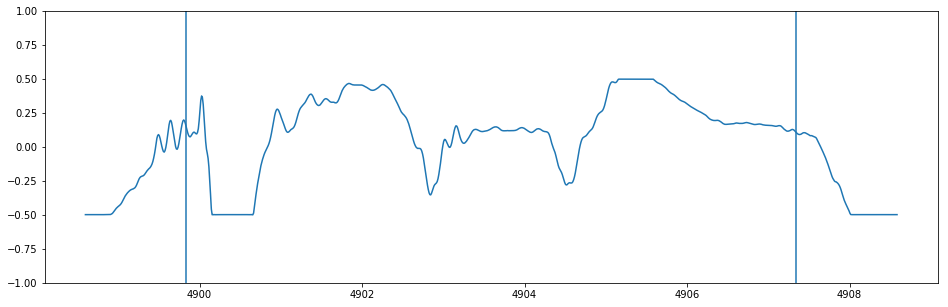

In [9]:
import matplotlib.pyplot as plt
import numpy as np

record = dataset_validation.records[1]

index_spindle = 30
window_duration = 5

# retrive spindle at the right index
spindle_start = float(predictions[record][0][index_spindle][0]) / sampling_frequency
spindle_end = float(predictions[record][0][index_spindle][1]) / sampling_frequency

# center data window on annotated spindle 
start_window = spindle_start + (spindle_end - spindle_start) / 2 - window_duration
stop_window = spindle_start + (spindle_end - spindle_start) / 2 + window_duration

# Retrieve EEG data at right index
index_start = int(start_window * sampling_frequency)
index_stop = int(stop_window * sampling_frequency)
y = dataset_validation.signals[record]["data"][0][index_start:index_stop]

# Build corresponding time support
t = start_window + np.cumsum(np.ones(index_stop - index_start) * 1 / sampling_frequency)

plt.figure(figsize=(16, 5))
plt.plot(t, y)
plt.axvline(spindle_end)
plt.axvline(spindle_start)
plt.ylim([-1, 1])
plt.show()

In [10]:
dataset_validation.records[1]

'8.h5'

In [96]:
data_sample = dataset_validation[0]

In [97]:
data_sample[1]*9000

tensor([[ 719., 1919.,    0.],
        [4219., 4419.,    0.]])

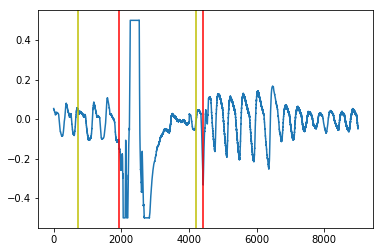

In [101]:
plt.plot(data_sample[0][0])
for event in data_sample[1]:
    plt.axvline(event[0]*9000, color="y")
    plt.axvline(event[1]*9000, color="r")

In [105]:
pred = net(data_sample[0].unsqueeze(0).to(0))
pred

(tensor([[[-0.2517, -0.4655],
          [ 0.8509, -0.8245],
          [-0.2599,  0.9015],
          [-0.2631,  0.4243],
          [-0.3949, -0.8989],
          [ 0.5329,  0.0442],
          [ 0.0280, -0.2509],
          [-2.7309,  0.4925],
          [-0.4273, -0.0943],
          [-1.4363,  0.1610]]], device='cuda:0', grad_fn=<ViewBackward>),
 tensor([[[ 0.0675, -0.0713],
          [-0.0947,  0.0778],
          [-0.4321,  0.4806],
          [-1.1010,  1.0547],
          [ 0.1050, -0.0558],
          [ 0.2683, -0.2299],
          [-0.2882,  0.2486],
          [ 0.2021, -0.2407],
          [ 0.1850, -0.1494],
          [ 0.5670, -0.5519]]], device='cuda:0', grad_fn=<ViewBackward>),
 tensor([[0.0472, 0.1889],
         [0.1417, 0.1889],
         [0.2361, 0.1889],
         [0.3306, 0.1889],
         [0.4250, 0.1889],
         [0.5194, 0.1889],
         [0.6139, 0.1889],
         [0.7083, 0.1889],
         [0.8028, 0.1889],
         [0.8972, 0.1889]]))

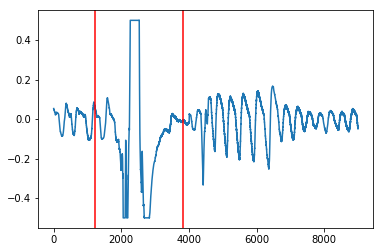

In [103]:
pred = net.predict(data_sample[0].unsqueeze(0).to(0))[0][0]
plt.plot(data_sample[0][0])
plt.axvline(pred[0]*9000, color="r")
plt.axvline(pred[1]*9000, color="r")

In [19]:
import h5py
import os
import numpy as np
from dosed.preprocessing.normalizers import quantile_normalize

q_n = quantile_normalize(0.0001, 0.9999)

with h5py.File(os.path.join(h5_directory, "8.h5")) as f:
    x = f["SP"]
    x = q_n(x)
    plt.plot(x[:100000])

KeyError: "Unable to open object (object 'SP' doesn't exist)"